In [1]:
cd ..

/home/martin/langevin_ggm


In [2]:
import numpy as np
from scipy.stats import wishart
from functools import partial
from inverse_covariance import QuicGraphicalLasso, ModelAverage
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import ggm_estimation.predictors as ggmp
import ggm_estimation.data_generation as gen
import ggm_estimation.utils as ut

%load_ext autoreload
%autoreload 2
%load_ext line_profiler

In [3]:
def compute_metrics(pred, true_supp):
    idx_nan = np.isnan(pred)
    prop_unknown = round(np.sum(idx_nan) / len(idx_nan), 2)
    prop_known_correct = round(np.sum(pred[~ idx_nan] == true_supp[~ idx_nan]) / len(pred[~ idx_nan]), 2)
    prop_correct = round(np.sum(pred == true_supp) / len(pred), 2)
    return prop_unknown, prop_known_correct, prop_correct

In [4]:
max_nodes = 25
num_obs = 20
lambda_fun = ut.lambda_glasso_selector(graph_type="deezer", nans=1.0, nans_proportional=True, one_zero_ratio=None)
n_bootstrap = 50
margins = np.linspace(0.01, 0.49, 50)
n_sim = 100

# Prior model
model_file = ("scorematching_gnn/exp/deezer_ego/edp-gnn_train_deezer_ego__Jun-14-14-14-11_1489048/models/" +
                "train_deezer_ego_[0.03, 0.08222222, 0.13444444, 0.18666667, 0.23888889, 0.29111111, 0.34333333, 0.39555556, 0.44777778, 0.5].pth")
# Graph creation function
graph_generator = partial(gen.load_graph_dataset, filename="scorematching_gnn/data/test_deezer_ego.pkl")

In [9]:
metrics = {
    "quic": {"prop_unknown": [], "prop_known_correct": [], "prop_correct": []},
    "quic_ma": {"prop_unknown": [], "prop_known_correct": [], "prop_correct": []},
    "graphical_lasso": {"prop_correct": []}
}
stability_selector_manual = ggmp.StabilitySelector(n_bootstrap, lambda_fun, mode="manual", n_jobs=1)
stability_selector_auto = ggmp.StabilitySelector(n_bootstrap, lambda_fun, mode="auto", n_jobs=1)

for A in tqdm(graph_generator(n_sim=n_sim)):
    try:
        A_obs, X_obs = gen.simulate_ggm(A, num_obs, nans=0.0, one_zero_ratio=None, n_proportional=True,
                                        psd_trials=10, 
                                        prior_Theta=lambda num_nodes: wishart(num_nodes, np.eye(num_nodes) * 10 / num_nodes), 
                                        logger=None)
    except RuntimeError:
        continue
    true_supp = A[np.triu_indices_from(A, k=1)]

    probs_auto = stability_selector_auto.generate_sample(X_obs)
    probs_manual = stability_selector_manual.generate_sample(X_obs)

    # Plot the accuracy as a function of the margin

    for margin in margins:
        pred_manual = stability_selector_manual.threshold_probabilities(probs_manual, margin)[np.triu_indices_from(A, k=1)]
        prop_unknown, prop_known_correct, prop_correct = compute_metrics(pred_manual, true_supp)
        metrics["quic"]["prop_unknown"].append(prop_unknown)
        metrics["quic"]["prop_known_correct"].append(prop_known_correct)
        metrics["quic"]["prop_correct"].append(prop_correct)

        pred_auto = stability_selector_auto.threshold_probabilities(probs_auto, margin)[np.triu_indices_from(A, k=1)]
        prop_unknown, prop_known_correct, prop_correct = compute_metrics(pred_auto, true_supp)
        metrics["quic_ma"]["prop_unknown"].append(prop_unknown)
        metrics["quic_ma"]["prop_known_correct"].append(prop_known_correct)
        metrics["quic_ma"]["prop_correct"].append(prop_correct)

for key in metrics:
    for metric in metrics[key]:
        metrics[key][metric] = np.array(metrics[key][metric]).reshape((-1, len(margins))).mean(axis=0)

  0%|          | 0/100 [00:00<?, ?it/s]

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   12.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
/tmp/ipykernel_54645/3407695938.py:4: RuntimeWarning: invalid value encountered in scalar divide
  prop_known_correct = round(np.sum(pred[~ idx_nan] == true_supp[~ idx_nan]) / len(pred[~ idx_nan]), 2)
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.8s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.5s
/tmp/ipykernel_54645/3407695938.py:4: RuntimeWarning: invalid value encountered in scalar divide
  prop_known_correct = round(np.sum(pred[~ idx_nan] == true_supp[~ idx_nan]) / len(pred[~ idx_nan]), 2)
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elaps

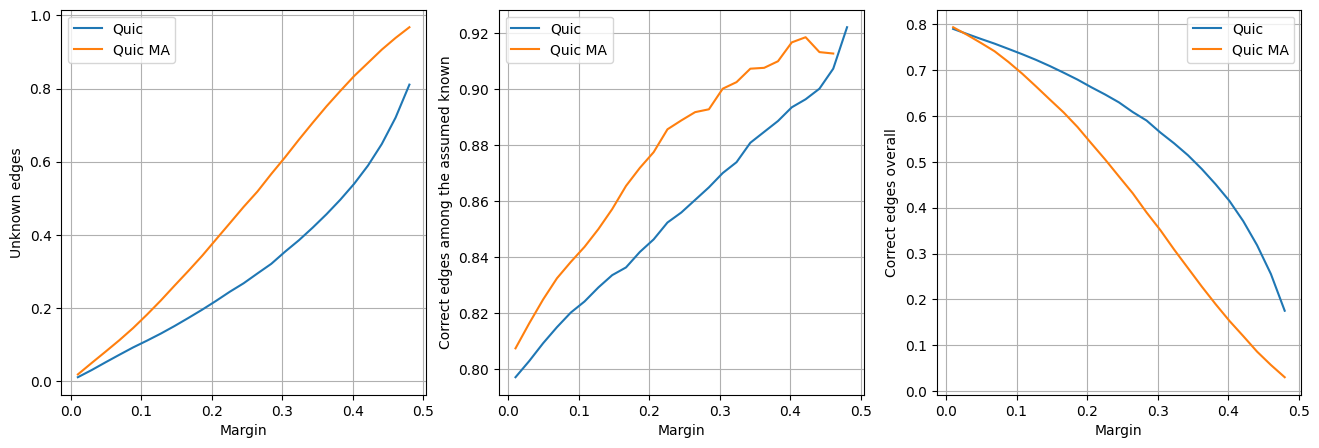

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(16, 5))
ylabels = {
    "prop_unknown": "Unknown edges",
    "prop_known_correct": "Correct edges among the assumed known",
    "prop_correct": "Correct edges overall"

}
for i, metric in enumerate(["prop_unknown", "prop_known_correct", "prop_correct"]):
    ax[i].plot(margins[::2], metrics["quic"][metric][::2], label="Quic")
    ax[i].plot(margins[::2], metrics["quic_ma"][metric][::2], label="Quic MA")
    ax[i].set_xlabel("Margin")
    ax[i].set_ylabel(ylabels[metric])
    ax[i].legend()
    ax[i].grid()
plt.show()